## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from sklearn.utils import shuffle
from typing import List
from numpy.typing import NDArray

In [52]:
# plot confusion matrix
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

# plot calibration curve
def plot_calibration_curve(pred_probs, test_y, n_bins=10):
    # Ensure inputs are NumPy arrays
    pred_probs = np.array(pred_probs)
    test_y = np.array(test_y)

    # Create bins
    bin_edges = np.linspace(pred_probs.min(), pred_probs.max(), n_bins + 1)

    # Initialize lists for storing results
    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(bin_edges) - 1):
        # Identify predictions within the current bin
        mask = (pred_probs > bin_edges[i]) & (pred_probs <= bin_edges[i + 1])
        if np.sum(mask) > 0:  # Skip empty bins
            # Compute empirical probability and midpoint of the bin
            empirical_probs.append(np.mean(test_y[mask]))
            pred_probs_midpoints.append((bin_edges[i] + bin_edges[i + 1]) / 2)

    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o', label='XGBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
    plt.title("Calibration Curve for XGBoost", fontsize=16)
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Empirical Probability', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# plot calibration curve for multiple models with ECE
def plot_overall_calibration_bars(
    y_true: NDArray,
    pred_probs: NDArray,
    n_bins: int = 10,
) -> float:
    # Input validation
    if y_true.shape != pred_probs.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} != pred_probs {pred_probs.shape}")
    if n_bins <= 0:
        raise ValueError(f"n_bins must be positive, got {n_bins}")
    
    # Get predictions and confidence scores
    confidence = np.max(pred_probs, axis=1)
    predicted_class = np.argmax(pred_probs, axis=1)
    true_class = np.argmax(y_true, axis=1)
    
    # Create confidence bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidence, bins=bin_edges, right=False)
    
    # Calculate metrics per bin
    avg_confidence: List[float] = []
    avg_accuracy: List[float] = []
    bin_counts: List[int] = []
    
    for i in range(1, len(bin_edges)):
        bin_mask = (bin_indices == i)
        bin_size = np.sum(bin_mask)
        
        if bin_size > 0:
            bin_confidence = np.mean(confidence[bin_mask])
            bin_accuracy = np.mean(true_class[bin_mask] == predicted_class[bin_mask])
            avg_confidence.append(bin_confidence)
            avg_accuracy.append(bin_accuracy)
            bin_counts.append(bin_size)
        else:
            avg_confidence.append(np.nan)
            avg_accuracy.append(np.nan)
            bin_counts.append(0)
    
    # Compute ECE (ignoring empty bins)
    valid_bins = ~np.isnan(avg_accuracy)
    ece = np.sum(
        np.abs(np.array(avg_accuracy)[valid_bins] - np.array(avg_confidence)[valid_bins]) 
        * (np.array(bin_counts)[valid_bins] / len(confidence))
    )
    
    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(n_bins)
    
    # Convert NaN to 0 for plotting
    plot_accuracy = np.nan_to_num(avg_accuracy)
    plot_confidence = np.nan_to_num(avg_confidence)
    
    plt.bar(x - bar_width/2, plot_accuracy, bar_width, 
            label="Accuracy", alpha=0.7)
    plt.bar(x + bar_width/2, plot_confidence, bar_width, 
            label="Average Confidence", alpha=0.7)
    
    # Add bin counts as text
    for i in range(n_bins):
        if bin_counts[i] > 0:
            plt.text(x[i], max(plot_accuracy[i], plot_confidence[i]) + 0.02,
                    str(bin_counts[i]), ha='center', va='bottom', fontsize=8)
    
    plt.axhline(1.0, linestyle='--', color='gray', linewidth=0.8)
    plt.title(f"Overall Calibration  (ECE: {ece:.3f})")
    plt.xlabel("Confidence Bins")
    plt.ylabel("Accuracy / Confidence")
    plt.xticks(x, [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" 
                   for i in range(n_bins)], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"ECE: {ece:.3f}")

# mixUp data
def mixup_data(X, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    indices = np.random.permutation(X.shape[0])
    X_mix = lam * X + (1 - lam) * X[indices]
    y_mix = lam * y + (1 - lam) * y[indices]
    return X_mix, y_mix

# Augment data with mixup
def augment_with_mixup(X, y, alpha=0.4, repeat=3):
    X_augmented = []
    y_augmented = []
    for _ in range(repeat):
        X_mix, y_mix = mixup_data(X, y, alpha)
        X_augmented.append(X_mix)
        y_augmented.append(y_mix)
    
    X_augmented = np.vstack([X] + X_augmented)  # Original + augmented
    y_augmented = np.vstack([y] + y_augmented)  # Original + augmented
    
    return X_augmented, y_augmented

# Label smoothing
def label_smoothing(y: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
    if not (0.0 <= epsilon <= 1.0):
        raise ValueError(f"Smoothing factor epsilon must be in [0, 1], got {epsilon}")

    n_classes = y.shape[1]
    smoothed_labels = (1 - epsilon) * y + epsilon / n_classes
    return smoothed_labels



## Data Loading and Preprocessing

In [3]:
# load data
data = pd.read_csv('Knowledge_base_train.csv')
print(len(data))
features_order = data.columns[1:]
#save the order of the features
with open('features_order.pkl', 'wb') as f:
    pickle.dump(features_order, f)
data.head()

400


,class,num_clients,Sum of Instances in Clients,Max. Of Instances in Clients,Min. Of Instances in Clients,Stddev of Instances in Clients,Average Dataset Missing Values %,Min Dataset Missing Values %,Max Dataset Missing Values %,Stddev Dataset Missing Values %,...,Min No. Of Insignificant Lags in Target,Stddev No. Of Insignificant Lags in Target,Avg. No. Of Seasonality Components in Target,Max No. Of Seasonality Components in Target,Min No. Of Seasonality Components in Target,Stddev No. Of Seasonality Components in Target,Average Fractal Dimensionality Across Clients of Target,Maximum Period of Seasonality Components in Target Across Clients,Minimum Period of Seasonality Components in Target Across Clients,Entropy of Target Stationarity
0,XGBRegressor,10,13821,1383,1382,0.300000,4.992466,4.121475,5.571635,0.448970,...,0,0,2,2,2,0,0.009829,13,2,0.325083
1,XGBRegressor,5,4031,807,806,0.400000,4.762946,3.970223,6.203474,0.875041,...,0,0,0,0,0,0,0.033774,0,0,0.673012
2,HUBERREGRESSOR,5,17280,3456,3456,0.000000,5.104167,4.745370,5.295139,0.188945,...,2,0,0,0,0,0,0.017802,0,0,0.673012
3,LinearSVR,5,6911,1383,1382,0.400000,4.934113,4.052098,5.571635,0.524086,...,1,0,0,0,0,0,0.390252,0,0,0.000000
4,XGBRegressor,15,24181,1613,1612,0.249444,4.966717,3.535980,6.389578,0.693981,...,0,0,1,1,1,0,0.014879,4,4,0.392674


In [4]:
X = data.drop(['class'], axis=1)
y = pd.get_dummies(data['class'])
class_names_order = y.columns
#save the order of the classes
with open('class_names_order.pkl', 'wb') as f:
    pickle.dump(class_names_order, f)
print(X.shape, y.shape)

(400, 57) (400, 6)


**The dataset is too small**

In [5]:
# split data train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(320, 57) (80, 57) (320, 6) (80, 6)


In [6]:
# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Building

### Befor calibrating the model

In [7]:
# train xgboost
model_base = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    random_state=42
)
model_base.fit(X_train, y_train.values.argmax(axis=1))
print('XGBoost accuracy:', model_base.score(X_test, y_test.values.argmax(axis=1)))

XGBoost accuracy: 0.55


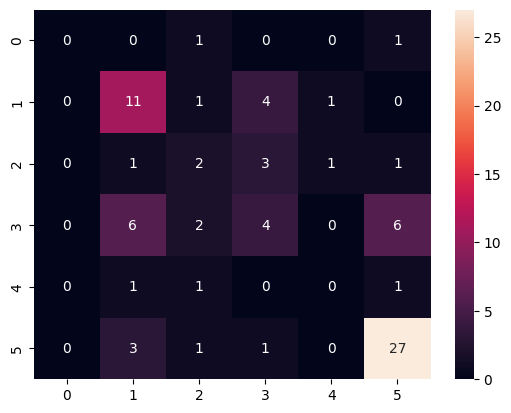

In [8]:
plot_confusion_matrix(model_base, X_test, y_test.values.argmax(axis=1))

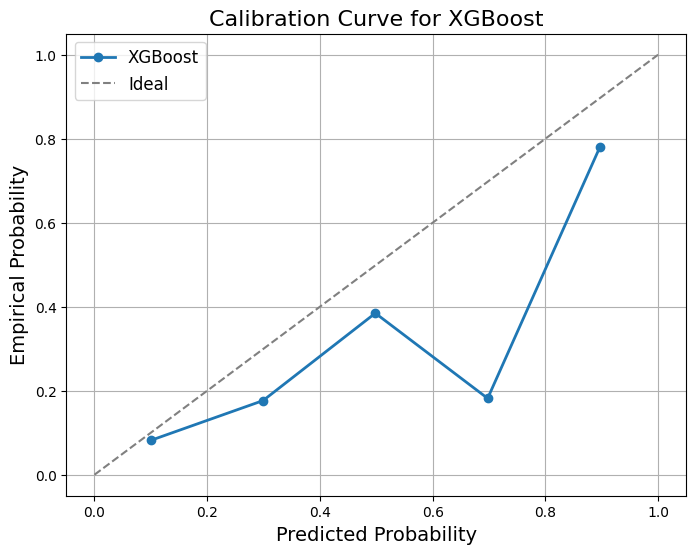

In [9]:
plot_calibration_curve(model_base.predict_proba(X_test), y_test.values, n_bins=5)

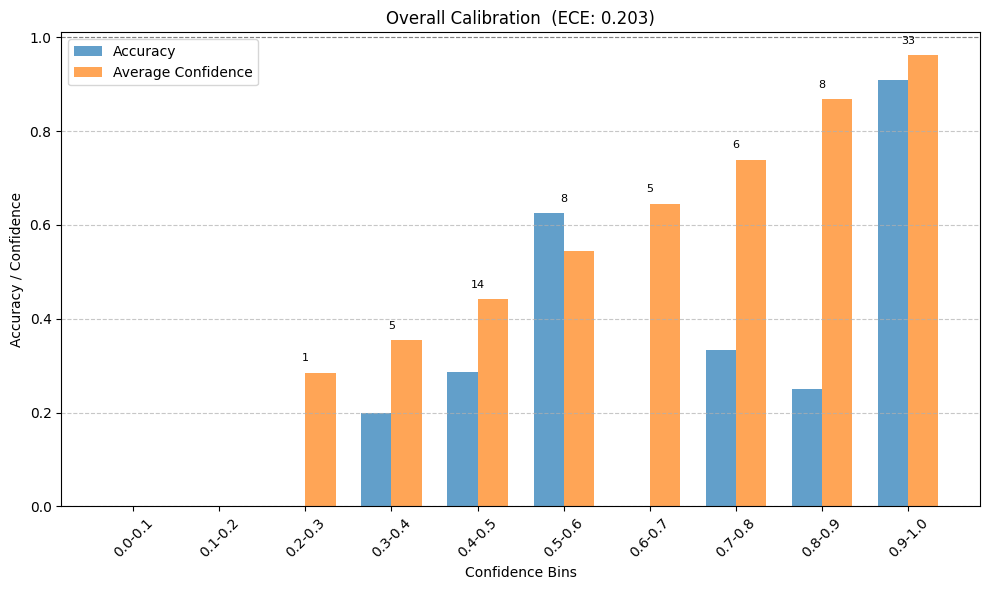

ECE: 0.203


In [53]:
plot_overall_calibration_bars(y_test.values, model_base.predict_proba(X_test), n_bins=10)

### After calibrating the model

#### Using mixUp 

In [11]:
x_train_mix, y_train_mix = augment_with_mixup(X_train, y_train.values, alpha=0.4, repeat=10)
# shuffle data
x_train_mix, y_train_mix = shuffle(x_train_mix, y_train_mix)
print(x_train_mix.shape, y_train_mix.shape)

(3520, 57) (3520, 6)


#### Using Label Smoothing

In [12]:
label_smoothing_factor = 0.3
y_train_smoothed = label_smoothing(y_train_mix, epsilon=label_smoothing_factor)

In [13]:
print(y_train_smoothed)

[[0.05       0.05       0.05       0.05       0.05       0.75      ]
 [0.05       0.42088206 0.05       0.37911794 0.05       0.05      ]
 [0.05       0.75       0.05       0.05       0.05       0.05      ]
 ...
 [0.05       0.05       0.73182241 0.05       0.05       0.06817759]
 [0.05       0.05       0.05       0.05760466 0.05       0.74239534]
 [0.05       0.3751214  0.05       0.4248786  0.05       0.05      ]]


In [22]:
# xgboost
model = xgb.XGBClassifier(objective="multi:softprob",
    n_estimators=300,
    max_depth=4,
    learning_rate=0.015,
    random_state=42)
model.fit(x_train_mix, np.argmax(y_train_smoothed, axis=1))
# evaluate model
print('XGBoost accuracy:', model.score(X_test, y_test.values.argmax(axis=1)))

XGBoost accuracy: 0.625


In [55]:
# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

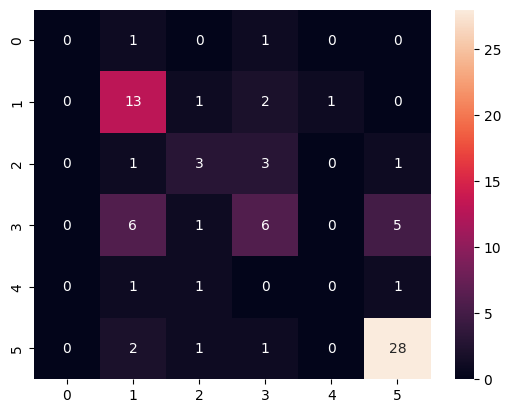

In [45]:
plot_confusion_matrix(model, X_test, y_test.values.argmax(axis=1))

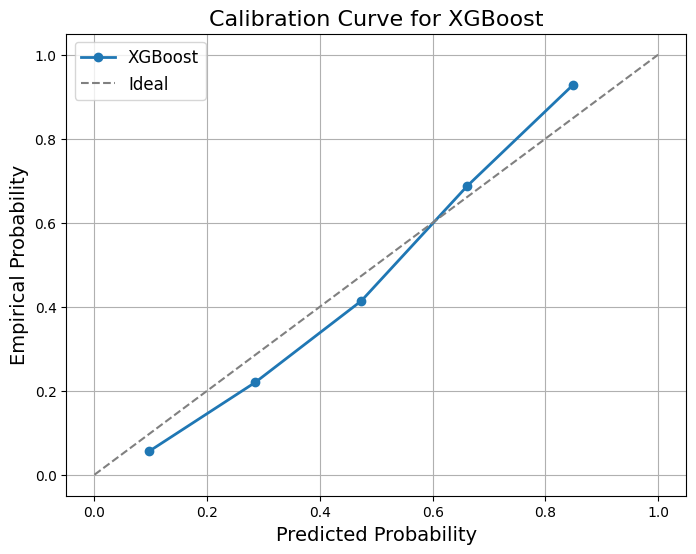

In [46]:
plot_calibration_curve(model.predict_proba(X_test), y_test.values, n_bins=5)

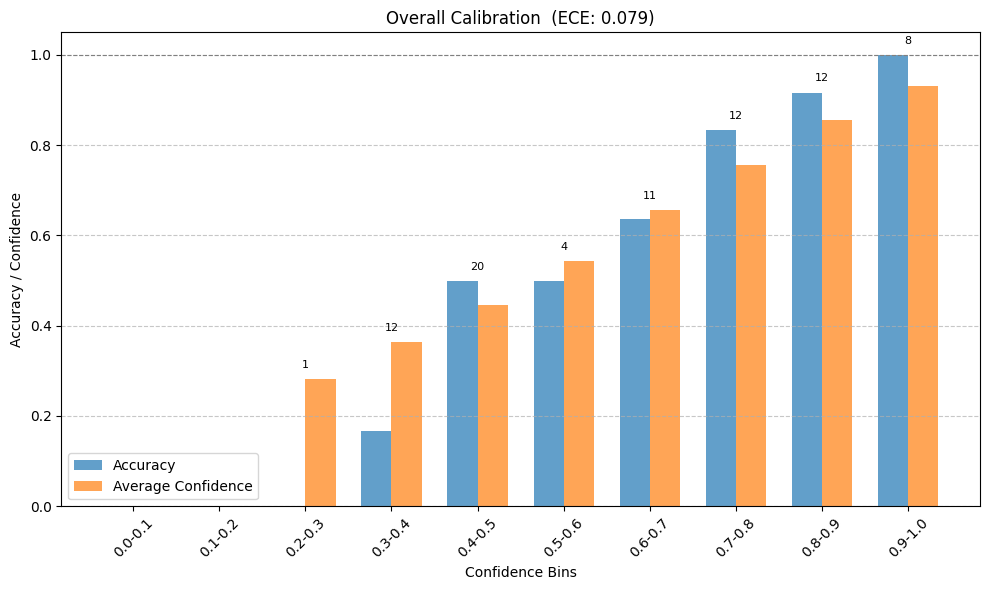

ECE: 0.079


In [54]:
plot_overall_calibration_bars(y_test.values, model.predict_proba(X_test), n_bins=10)

In [48]:
def custom_predict(model, X):
    class_names = pickle.load(open('class_names_order.pkl', 'rb'))
    x = X.reshape(1, -1)
    y_pred = model.predict_proba(x)
    y_pred = pd.DataFrame(y_pred, columns=class_names).to_dict(orient="records")[0]
    # sort the predictions by probability
    y_pred = dict(sorted(y_pred.items(), key=lambda x: x[1], reverse=True))
    # print(y_pred)
    return y_pred

def check_y_true(y_true):
    class_names = pickle.load(open('class_names_order.pkl', 'rb'))
    return class_names[y_true]


In [49]:
# correct prediction with high confidence
n=3
x = X_test[n]
y_true = y_test.values[n]
print(check_y_true(y_true))
print(custom_predict(model, x))


Index(['XGBRegressor'], dtype='object')
{'XGBRegressor': 0.7623510956764221, 'LinearSVR': 0.12358208000659943, 'HUBERREGRESSOR': 0.04918121173977852, 'LASSO': 0.02857040800154209, 'QUANTILEREGRESSOR': 0.026258954778313637, 'ELASTICNETCV': 0.010056227445602417}


In [50]:
# wrong prediction with low confidence
n=0
x = X_test[n]
y_true = y_test.values[n]
print(check_y_true(y_true))
print(custom_predict(model, x))

Index(['LASSO'], dtype='object')
{'LASSO': 0.44007062911987305, 'HUBERREGRESSOR': 0.21302612125873566, 'LinearSVR': 0.1809139996767044, 'XGBRegressor': 0.13449101150035858, 'QUANTILEREGRESSOR': 0.01803099550306797, 'ELASTICNETCV': 0.013467232696712017}


In [51]:
# correct prediction with very high confidence
n=4
x = X_test[n]
y_true = y_test.values[n]
print(check_y_true(y_true))
print(custom_predict(model, x))

Index(['XGBRegressor'], dtype='object')
{'XGBRegressor': 0.9194003343582153, 'LASSO': 0.02566218003630638, 'QUANTILEREGRESSOR': 0.02064700424671173, 'LinearSVR': 0.01570538803935051, 'HUBERREGRESSOR': 0.01444158609956503, 'ELASTICNETCV': 0.004143456928431988}
